<a href="https://colab.research.google.com/github/youkjang/Machine-Learning-Deep-Learning-Practice/blob/main/storm_prediction_ann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Storm Prediction

This notebook is based on ams-ml-python-course in reference. The artificial neural network model is used for the storm prediction.

### Input variables
- REFL_COM_mean (composite reflectivity)

- U10_mean, U10_max (10 m west-east wind component in m/s)

- V10_mean, V10_max (10 m south-north wind component in m/s)

- T2_mean, T2_max (2 m temperature in Kelvin)

### Output variables
- Based on Vorticity, strong rotation as 1 and weak or no rotation as 0

### data
https://github.com/djgagne/ams-ml-python-course/blob/master/download_data.py
### Reference
https://github.com/djgagne/ams-ml-python-course/blob/master/module_3/ML_Short_Course_Module_3_Deep_Learning.ipynb

1. Exploratory Data Analysis: heatmap, data description, and histogram of vorticity.
2. Preprocessing: select inputs, split the datasets, and normalization
3. Model training: optimize artificial neural network with training data
4. Prediction with test data
5. Evaluate the model with prediction and test data.  

In this notebook, U10_max, V10_max, and T2_max are added as input variables. heatmap of all input varibles and vorticity for storm is plotted.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import glob

Load CSV file

In [2]:
csv_files = sorted(glob.glob("*.csv"))
csv_data_list = []
for csv_file in csv_files:
    print(csv_file)
    csv_data_list.append(pd.read_csv(csv_file))
csv_data = pd.concat(csv_data_list, ignore_index=True)
del csv_data_list

track_step_NCARSTORM_d01_20101024-0000.csv
track_step_NCARSTORM_d01_20101122-0000.csv
track_step_NCARSTORM_d01_20110201-0000.csv
track_step_NCARSTORM_d01_20110308-0000.csv
track_step_NCARSTORM_d01_20110326-0000.csv
track_step_NCARSTORM_d01_20110404-0000.csv
track_step_NCARSTORM_d01_20110414-0000.csv
track_step_NCARSTORM_d01_20110420-0000.csv
track_step_NCARSTORM_d01_20110425-0000.csv
track_step_NCARSTORM_d01_20110509-0000.csv
track_step_NCARSTORM_d01_20110522-0000.csv
track_step_NCARSTORM_d01_20110527-0000.csv
track_step_NCARSTORM_d01_20110605-0000.csv
track_step_NCARSTORM_d01_20110610-0000.csv
track_step_NCARSTORM_d01_20110615-0000.csv
track_step_NCARSTORM_d01_20110620-0000.csv
track_step_NCARSTORM_d01_20110625-0000.csv
track_step_NCARSTORM_d01_20110704-0000.csv
track_step_NCARSTORM_d01_20110712-0000.csv
track_step_NCARSTORM_d01_20111116-0000.csv
track_step_NCARSTORM_d01_20120218-0000.csv
track_step_NCARSTORM_d01_20120315-0000.csv
track_step_NCARSTORM_d01_20120323-0000.csv
track_step_

## Exploratory Data Analysis

In [3]:
csv_data.head()

,Step_ID,Track_ID,Ensemble_Name,Ensemble_Member,Run_Date,Valid_Date,Forecast_Hour,Valid_Hour_UTC,Duration,Centroid_Lon,Centroid_Lat,Centroid_X,Centroid_Y,Storm_Motion_U,Storm_Motion_V,REFL_COM_mean,REFL_COM_max,REFL_COM_min,REFL_COM_std,REFL_COM_percentile_10,REFL_COM_percentile_25,REFL_COM_percentile_50,REFL_COM_percentile_75,REFL_COM_percentile_90,U10_mean,U10_max,U10_min,U10_std,U10_percentile_10,U10_percentile_25,U10_percentile_50,U10_percentile_75,U10_percentile_90,V10_mean,V10_max,V10_min,V10_std,V10_percentile_10,V10_percentile_25,V10_percentile_50,V10_percentile_75,V10_percentile_90,T2_mean,T2_max,T2_min,T2_std,T2_percentile_10,T2_percentile_25,T2_percentile_50,T2_percentile_75,T2_percentile_90,RVORT1_MAX-future_mean,RVORT1_MAX-future_max,RVORT1_MAX-future_min,RVORT1_MAX-future_std,RVORT1_MAX-future_percentile_10,RVORT1_MAX-future_percentile_25,RVORT1_MAX-future_percentile_50,RVORT1_MAX-future_percentile_75,RVORT1_MAX-future_percentile_90,HAIL_MAXK1-future_mean,HAIL_MAXK1-future_max,HAIL_MAXK1-future_min,HAIL_MAXK1-future_std,HAIL_MAXK1-future_percentile_10,HAIL_MAXK1-future_percentile_25,HAIL_MAXK1-future_percentile_50,HAIL_MAXK1-future_percentile_75,HAIL_MAXK1-future_percentile_90,area,eccentricity,major_axis_length,minor_axis_length,orientation,Matched,Max_Hail_Size,Num_Matches,Shape,Location,Scale
0,d01_REFL_COM_20101024-0000_12_12_000_00,d01_REFL_COM_20101024-0000_12_12_000,NCARSTORM,d01,2010-10-24 00:00:00,2010-10-24 12:00:00,12,12,1,-93.43888,31.44266,717223.93951,-733313.11177,0.0,0.0,42.71822,43.67072,40.97010,0.96199,41.41314,41.91508,42.97249,43.62384,43.63801,0.19710,0.86864,-0.46319,0.44857,-0.29858,-0.17834,0.27611,0.66999,0.71307,5.32790,7.17355,3.53556,1.37479,3.57072,4.28456,4.78568,6.74275,7.10965,293.14920,293.22021,293.05215,0.06001,293.05662,293.12073,293.17340,293.20276,293.21045,0.00028,0.00035,0.00021,0.00004,0.00024,0.00026,0.00027,0.00029,0.00033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,0.78628,4.27766,2.64302,-0.10555,0,0,0,0,0,0
1,d01_REFL_COM_20101024-0000_12_12_001_00,d01_REFL_COM_20101024-0000_12_12_001,NCARSTORM,d01,2010-10-24 00:00:00,2010-10-24 12:00:00,12,12,1,-93.06068,32.33814,744315.06633,-631051.55216,0.0,0.0,47.09285,54.19151,40.63351,3.34380,43.27050,44.62197,46.86275,49.64786,51.59267,-1.03154,-0.08395,-2.00645,0.48773,-1.62877,-1.32586,-1.08810,-0.79851,-0.28629,5.33612,7.07514,2.15228,1.44588,3.16599,4.44680,5.65116,6.44384,6.84668,292.00092,292.31110,291.73080,0.15644,291.81573,291.87878,291.98325,292.14569,292.21041,0.00153,0.00195,0.00068,0.00040,0.00085,0.00127,0.00170,0.00184,0.00191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35,0.47108,7.07588,6.24158,-1.33266,0,0,0,0,0,0
2,d01_REFL_COM_20101024-0000_12_15_002_00,d01_REFL_COM_20101024-0000_12_15_002,NCARSTORM,d01,2010-10-24 00:00:00,2010-10-24 12:00:00,12,12,1,-93.65033,32.43676,688274.83172,-624784.64092,0.0,0.0,45.53852,48.22308,40.77723,1.97809,42.59812,44.32117,45.83910,47.22936,47.66140,-0.21393,2.30970,-1.64158,0.90139,-1.27495,-0.81603,-0.36890,0.24072,0.98897,1.99015,5.40622,-2.73531,2.65494,-1.35803,-0.36154,2.77814,4.82195,5.23079,293.00864,293.55157,292.49957,0.32322,292.61641,292.71604,293.00183,293.26897,293.48459,0.00161,0.00241,0.00087,0.00048,0.00102,0.00121,0.00146,0.00207,0.00231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36,0.87636,9.90123,4.76900,-0.10405,0,0,0,0,0,0
3,d01_REFL_COM_20101024-0000_12_15_002_01,d01_REFL_COM_20101024-0000_12_15_002,NCARSTORM,d01,2010-10-24 00:00:00,2010-10-24 13:00:00,13,13,2,-93.28486,32.61097,720778.55632,-602667.71249,33000.0,21000.0,44.30976,47.98366,41.44846,1.61085,42.41405,43.40802,43.90155,45.34798,46.96363,1.27862,2.77090,-0.89391,0.93614,-0.03528,0.77566,1.39530,1.93714,2.37438,1.81628,6.85102,-1.48919,2.41741,-0.93601,-0.23556,1.29246,3.49259,5.38372,292.64368,293.38519,292.04929,0.38983,292.12880,292.26558,292.66022,292.91397,293.20261,0.00169,0.00233,0.00039,0.00041,0.00130,0.00149,0.00166,0.00199,0.00225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39,0.97896,16.76704,3.42129,-0.714

Heatmap

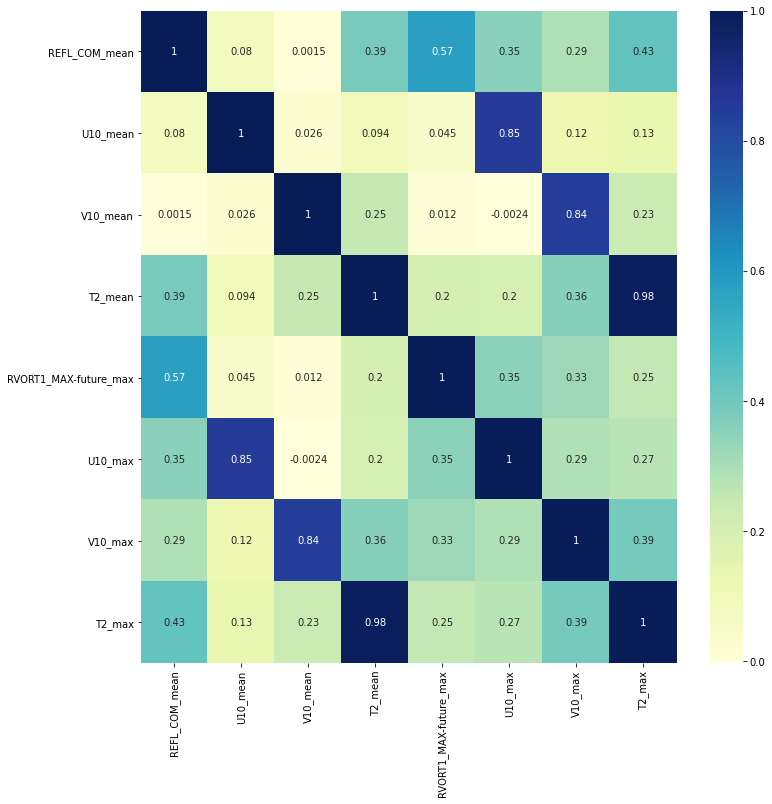

In [4]:
import seaborn as sns

sel_columns = ["REFL_COM_mean", "U10_mean", "V10_mean", "T2_mean","RVORT1_MAX-future_max",
               "U10_max","V10_max","T2_max"]

df1 = csv_data[sel_columns]

plt.figure(figsize=(12,12))
sns.heatmap(df1.corr(),annot=True,cmap='YlGnBu')
plt.show()

In [5]:
df1.describe()

,REFL_COM_mean,U10_mean,V10_mean,T2_mean,RVORT1_MAX-future_max,U10_max,V10_max,T2_max
count,121137.000000,121137.000000,121137.00000,121137.000000,121137.000000,121137.000000,121137.000000,121137.000000
mean,46.890579,0.327331,0.36504,289.465444,0.001931,3.662725,3.726053,290.743973
std,4.011562,4.251063,4.51375,6.963805,0.001565,5.206921,5.126733,7.168981
min,40.082820,-18.653700,-24.14743,262.921600,0.000000,-17.770740,-20.794570,263.147280
25%,43.788780,-2.449740,-2.48763,285.292210,0.000840,0.155720,0.537950,286.378970
50%,46.216210,0.274450,0.49327,290.714110,0.001540,3.500480,3.928650,291.790130
75%,49.183690,3.085180,3.35748,294.436310,0.002560,6.973020,7.103150,295.777500
max,69.642850,19.686640,18.61693,314.625730,0.023830,32.707960,31.773330,317.685700


RVORT1_MAX-future_max



(array([8.6860e+04, 2.7458e+04, 5.2730e+03, 1.1670e+03, 3.0400e+02,
        5.7000e+01, 1.2000e+01, 5.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.      , 0.002383, 0.004766, 0.007149, 0.009532, 0.011915,
        0.014298, 0.016681, 0.019064, 0.021447, 0.02383 ]),
 <a list of 10 Patch objects>)

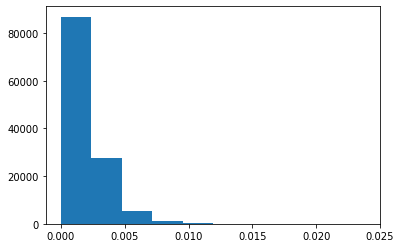

In [6]:
plt.hist(csv_data['RVORT1_MAX-future_max'])

## Pre-Processing for Deep Learning
## Select Variables
- input & output variables

In [7]:
input_columns = ["REFL_COM_mean", "U10_mean", "V10_mean", "T2_mean",
                 "U10_max", "V10_max", "T2_max"]
output_column = "RVORT1_MAX-future_max"

## Split dataset into trainning and test data

In [8]:
train_test_date = pd.Timestamp("2015-01-01")
valid_dates = pd.DatetimeIndex(csv_data["Valid_Date"])

- vorticity threshold in $s^{-1}$

In [9]:
out_threshold = 0.005

- Input training data : 2010-10-24 ~ 2014-11-24
- Output (Label) : RVORT1_MAX-future_max, strong rotation as 1 and weak or no rotation as 0

In [10]:
train_data = csv_data.loc[valid_dates < train_test_date, input_columns]

train_out = np.where(csv_data.loc[valid_dates < train_test_date, output_column] > out_threshold, 1, 0)

- Input test data: 2015-3-31 ~ 2017-3-30
- Output test: strong rotation as 1 and weak or no rotation as 0

In [11]:
test_data = csv_data.loc[valid_dates >= train_test_date, input_columns]

test_out = np.where(csv_data.loc[valid_dates >= train_test_date, output_column] > out_threshold, 1, 0)

## Normalize Input for Neural Network

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_norm = scaler.fit_transform(train_data)
test_norm = scaler.transform(test_data)
for i, input_col in enumerate(input_columns):
    print(f"{input_columns[i]:13s} Mean: {scaler.mean_[i]:0.3f} SD: {scaler.scale_[i]:0.3f}")

REFL_COM_mean Mean: 46.847 SD: 3.984
U10_mean      Mean: 0.450 SD: 4.348
V10_mean      Mean: 0.543 SD: 4.462
T2_mean       Mean: 289.409 SD: 6.932
U10_max       Mean: 3.764 SD: 5.261
V10_max       Mean: 3.898 SD: 5.066
T2_max        Mean: 290.693 SD: 7.124


## Artificial Neural Network

In [13]:
import tensorflow as tf

Initializing the ANN

In [14]:
ann = tf.keras.models.Sequential()

Adding the input layer and the first hidden layer

In [15]:
ann.add(tf.keras.layers.Dense(units = 6, activation='relu',input_shape=[7]))

Adding the second hidden layer

In [16]:
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))

Output layer

In [17]:
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

Compile the model

In [18]:
ann.compile(optimizer ='adam', loss='binary_crossentropy', metrics=['accuracy'] )

In [19]:
ann.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 48        
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


In [20]:
ann.fit(train_norm, train_out, epochs = 10, batch_size=128)

Epoch 1/10
597/597 [==============================] - 1s 1ms/step - loss: 0.6174 - accuracy: 0.7157
Epoch 2/10
597/597 [==============================] - 1s 1ms/step - loss: 0.1606 - accuracy: 0.9537
Epoch 3/10
597/597 [==============================] - 1s 1ms/step - loss: 0.1237 - accuracy: 0.9582
Epoch 4/10
597/597 [==============================] - 1s 1ms/step - loss: 0.1221 - accuracy: 0.9569
Epoch 5/10
597/597 [==============================] - 1s 1ms/step - loss: 0.1187 - accuracy: 0.9577
Epoch 6/10
597/597 [==============================] - 1s 1ms/step - loss: 0.1194 - accuracy: 0.9572
Epoch 7/10
597/597 [==============================] - 1s 1ms/step - loss: 0.1194 - accuracy: 0.9572
Epoch 8/10
597/597 [==============================] - 1s 1ms/step - loss: 0.1156 - accuracy: 0.9584
Epoch 9/10
597/597 [==============================] - 1s 1ms/step - loss: 0.1162 - accuracy: 0.9588
Epoch 10/10
597/597 [==============================] - 1s 1ms/step - loss: 0.1162 - accuracy: 0.9585

## Prediction

In [21]:
ann_preds = ann.predict(test_norm).ravel()

## Evaluation of Artificial Neural Network

In [23]:
from sklearn.metrics import mean_squared_error, roc_auc_score

small_model_auc = roc_auc_score(test_out, ann_preds)
small_model_mse = mean_squared_error(test_out, ann_preds)

print(f"AUC: {small_model_auc:0.3f}")
print(f"MSE: {small_model_mse:0.3f}")


AUC: 0.929
MSE: 0.034
